# Initial configuration

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
print(torch.__version__)
device = "cuda" if torch.cuda.is_available() else "cpu"
CACHE_DIR = "/scratch/chaijy_root/chaijy0/sstorks/.cache/huggingface"

1.13.0+cu117


# CaptainCook4D

## Data loading

In [14]:
VIDEO_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv" # Directory containing CaptainCook4D mp4s
ANNOTATIONS_DIR = "/nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/annotations"

Boilerplate code to load video frames from video files (from GPT4):

In [15]:
import cv2
import numpy as np

def get_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        raise IOError("Cannot open video file")
    
    return cap
    # remember to call cap.release() later

def extract_frames(cap, times):
    fps = cap.get(cv2.CAP_PROP_FPS)  # Frames per second
    frames = []

    for t in times:
        frame_number = int(t * fps)
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_number)
        ret, frame = cap.read()

        if ret:
            # Convert to RGB
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)            
            frames.append(frame)
        else:
            print(f"Warning: Frame at time {t} seconds could not be read.")
            frames.append(None)

    return frames

Other utils functions:

In [16]:
def generate_float_series(start, end, step):
    # Ensure step is a positive float
    step = abs(step)

    # Initialize the series with the start value
    series = [start]

    # Generate numbers in the series
    while start + step <= end:
        start += step
        series.append(start)

    # Check if the end value is already in the series
    if series[-1] != end:
        series.append(end)

    return series

Sample video: /nfs/turbo/coe-chaijy-unreplicated/datasets/captaincook4d/data/captain_cook_4d/hololens/sync/pv/29_7_360p.mp4
Recipe name: Caprese Bruschetta


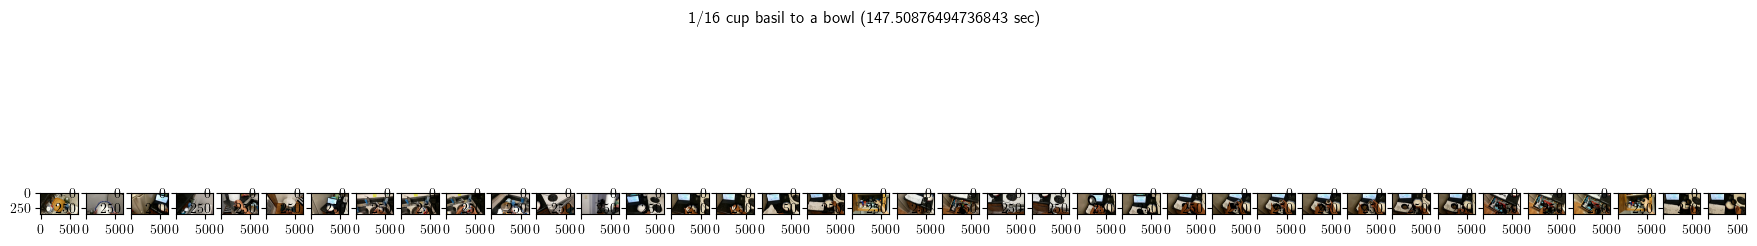

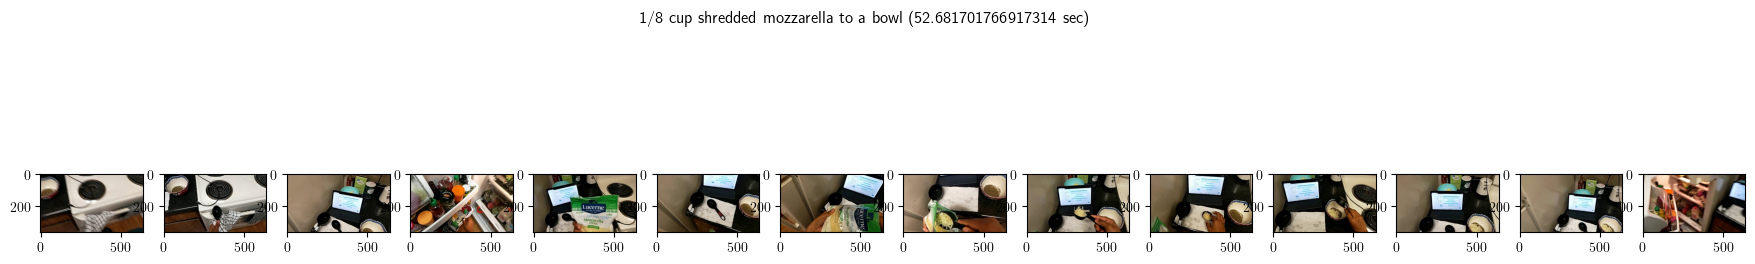

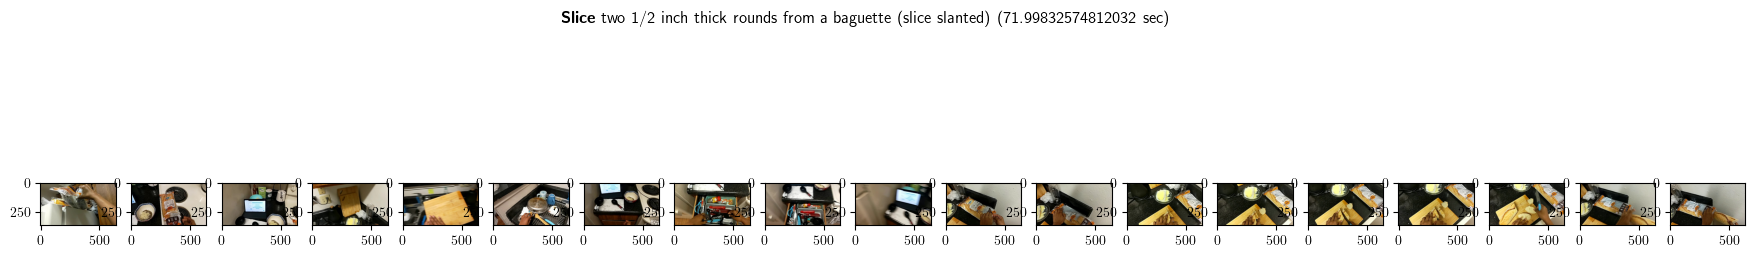

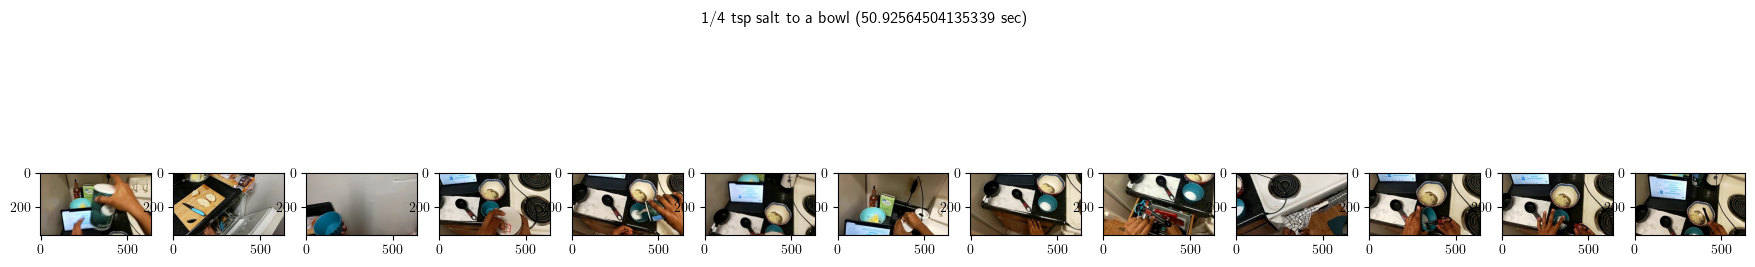

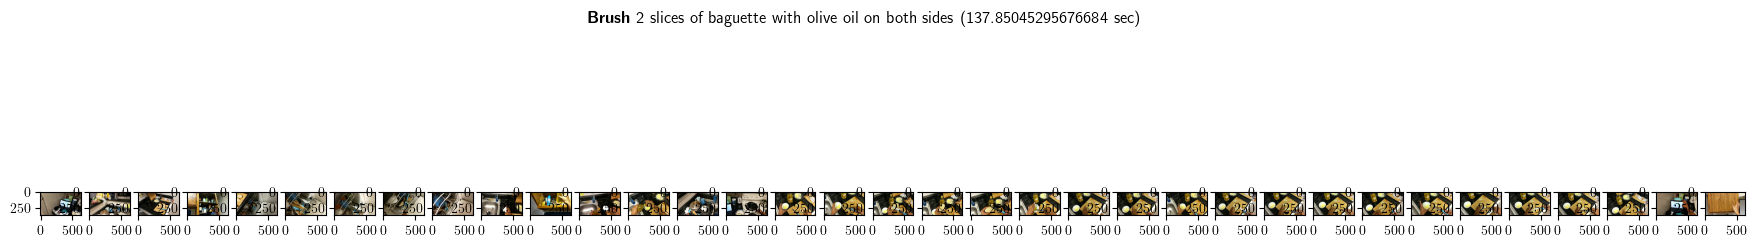

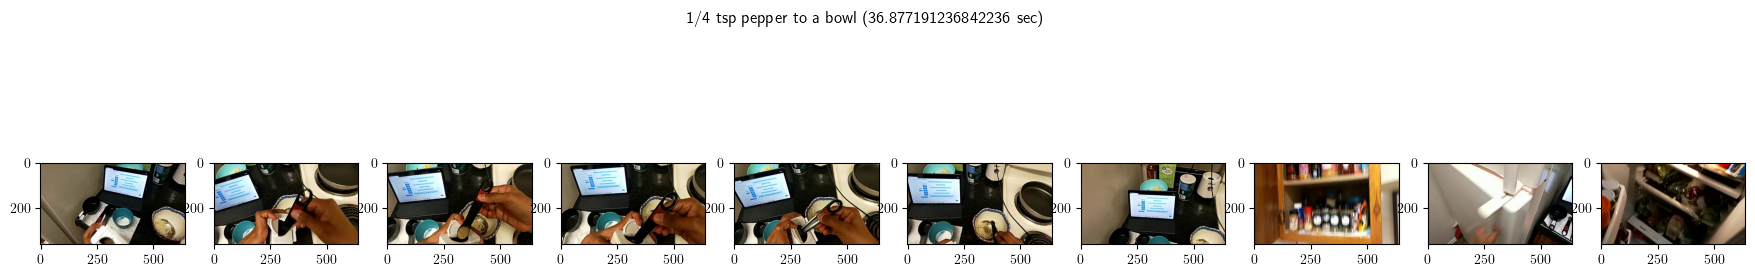

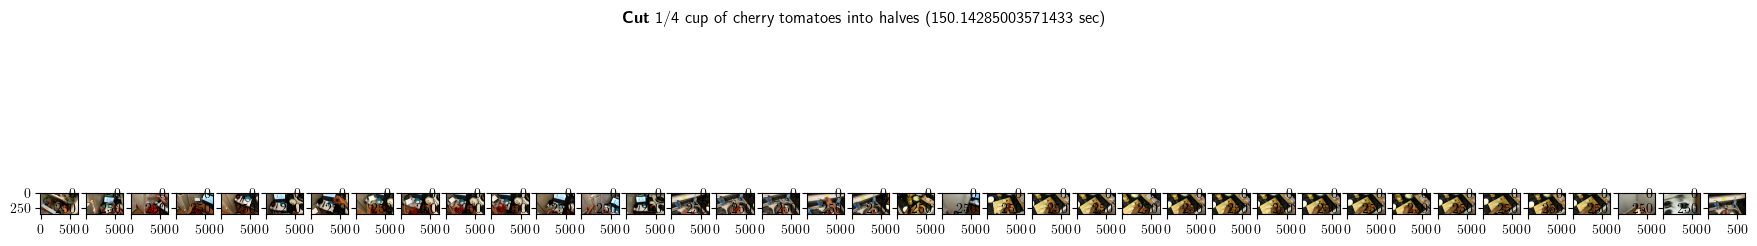

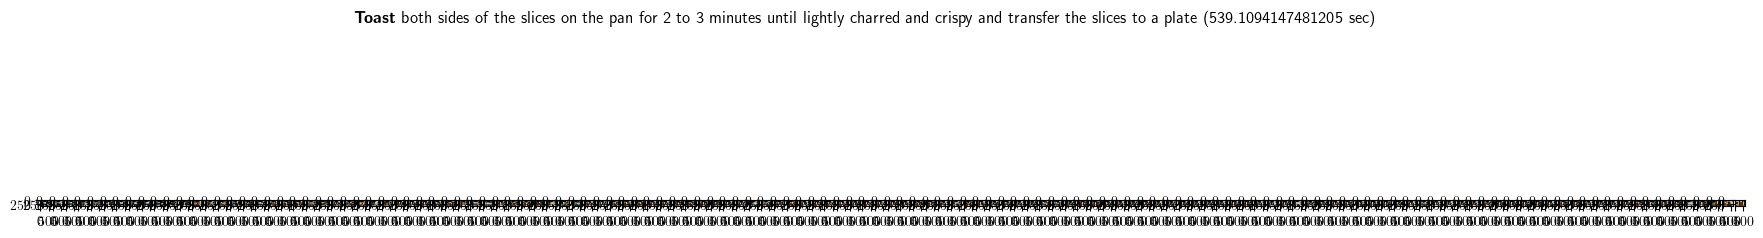

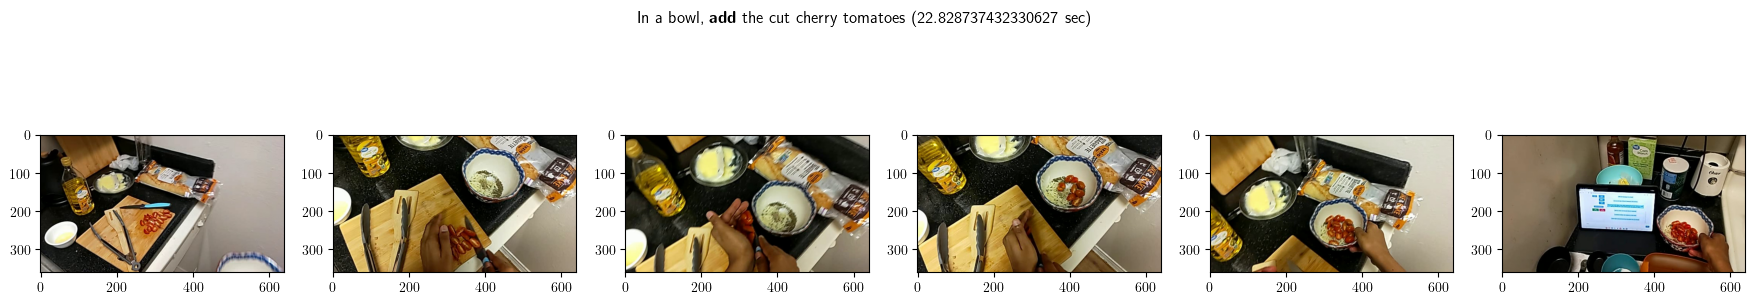

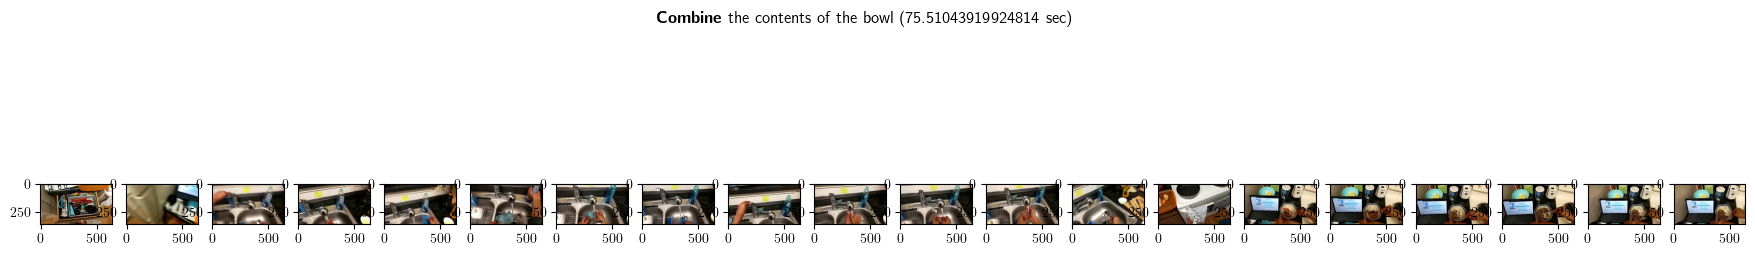

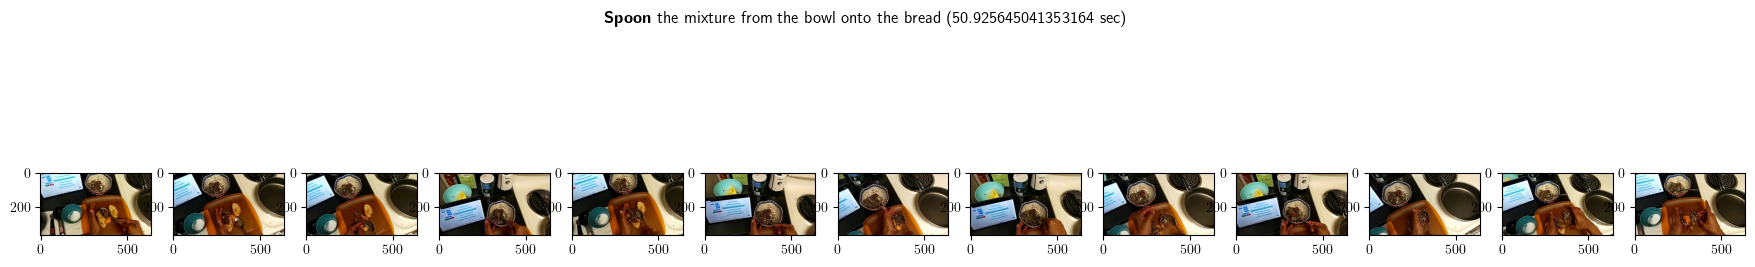

In [17]:
import os, json
from pprint import pprint
import matplotlib.pyplot as plt
from matplotlib import rc
rc('text', usetex=True)

# Pick a sample video from CaptainCook4D
all_video_files = os.listdir(VIDEO_DIR)
sample_video_path = [f for f in all_video_files if f.endswith('.mp4')][3]
sample_video_id = "_".join(sample_video_path.split('_')[:2])
sample_video_path = os.path.join(VIDEO_DIR, sample_video_path)
print("Sample video:", sample_video_path)
sample_video = get_video(sample_video_path)

step_annotations = json.load(open(os.path.join(ANNOTATIONS_DIR, "annotation_json/complete_step_annotations.json"), "r"))
print("Recipe name:", step_annotations[sample_video_id]["activity_name"])

all_frames = []

# Load step annotations for it and display precondition/effect frames
for step in step_annotations[sample_video_id]["steps"]:
    # Extract some keyframes for the action
    pnr = (step['start_time'] + step['end_time']) / 2.0 # take "point of no return" as midpoint of action
    step_duration = step['end_time'] - step['start_time']

    # Some steps are skipped
    if step_duration < 0.1:
        continue

    # TODO: this method of adjusting the start and end times still doesn't account for noise in labels. Maybe we can use segment anything or GLIP to smooth this a bit later.
    # ^ however, we might just end up running a model on several frames, e.g., 1s apart, so this may not matter - just for illustration purpose for now
    adjusted_start = step['start_time'] + min(step_duration * 0.05, 0.5) # Adjust the start time to be later by a maximum of 3 seconds
    adjusted_end = step['end_time'] - min(step_duration * 0.3, 3) # Adjust the end time to be earlier by a maximum of 3 seconds

    # times = [adjusted_start, pnr, adjusted_end]
    times = generate_float_series(adjusted_start, adjusted_end, 4.0) # ultimately, we'll want to look at every image frame in some regular interval to determine if there's a mistake
    frames = extract_frames(sample_video, times) 

    fig, axarr = plt.subplots(1, len(times), figsize=(22, 4))

    verb, action_description = step['description'].split("-")[0], "-".join(step['description'].split("-")[1:])
    stylized_title = action_description.replace(verb, r'\textbf{' + verb + '}')

    fig.suptitle(f"{stylized_title} ({step_duration} sec)")
    for frame, ax in zip(frames, axarr):
        if frame is not None:
            ax.imshow(frame)
    plt.show()
    
    all_frames.append(frames)

sample_video.release()

## Kosmos-2 demo

NOTE: [LLaVA-Grounding](https://arxiv.org/pdf/2312.02949.pdf) may also be a good comparison model here.

Load model:

In [7]:
import torch
print(torch.__version__)
print(torch.version.cuda)


1.13.0+cu117
11.7


In [8]:
from transformers import AutoProcessor, AutoModelForVision2Seq

MODEL_NAME = "microsoft/kosmos-2-patch14-224"

model = AutoModelForVision2Seq.from_pretrained("microsoft/kosmos-2-patch14-224")
processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
model.cuda()

print(model.device)

config.json:   0%|          | 0.00/4.45k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/6.66G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/534 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/191k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/4.70M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/32.0k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


cuda:0


Utility functions for Kosmos-2:

In [9]:
from PIL import Image
import torch
import os
import numpy as np
import cv2
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt

IMAGES_PATH = "/nfs/turbo/coe-chaijy/sstorks/simulation_informed_pcr4nlu/state_example_images/"

def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)

def draw_entity_boxes_on_image(image, entities, show=False, save_path=None):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    elif isinstance(image, str):
        if os.path.exists(image):
            pil_img = Image.open(image).convert("RGB")
            image = np.array(pil_img)[:, :, [2, 1, 0]]
            image_h = pil_img.height
            image_w = pil_img.width
        else:
            raise ValueError(f"invaild image path, {image}")
    elif isinstance(image, torch.Tensor):
        # pdb.set_trace()
        image_tensor = image.cpu()
        reverse_norm_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        reverse_norm_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])[:, None, None]
        image_tensor = image_tensor * reverse_norm_std + reverse_norm_mean
        pil_img = T.ToPILImage()(image_tensor)
        image_h = pil_img.height
        image_w = pil_img.width
        image = np.array(pil_img)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, (start, end), bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])
    if save_path:
        pil_image.save(save_path)
    if show:
        plt.imshow(pil_image)
        plt.show()
    return new_image


Zero-shot prompt:

Q: Are all the cherry tomatoes in the bowl?
A: Yes, all the tomatoes are in the small bowl.


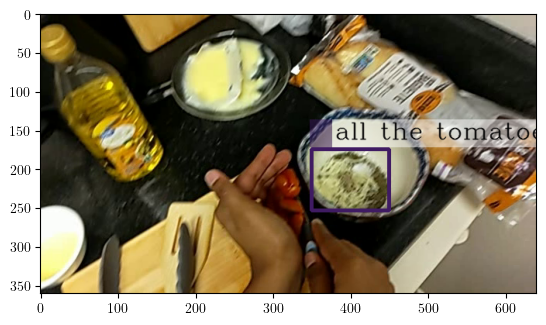

In [12]:
from PIL import Image
with torch.no_grad():
    
    # input_img = all_frames[8][0] # This should be an image of sliced tomatoes on only a cutting board
    # input_img = all_frames[8][1] # This should be an image of sliced tomatoes on a cutting board and in a bowl
    input_img = all_frames[8][2] # This should be an image of sliced tomatoes in only a bowl
    
    # prompt = "<grounding> An image of"
    # prompt = "<grounding> Q: Are all the cherry tomatoes in the bowl? A: "
    # prompt = "<grounding> Q: Are the tomatoes anywhere else besides the bowl? A: "
    # prompt = "<grounding> Q: Did the user successfully add the cut cherry tomatoes to a bowl? A: "
    # prompt = "<grounding> Q: Where are the cut cherry tomatoes? A: "
    # prompt = "<grounding> Q: What objects are in the scene? A: "
    # prompt = "<grounding> Q: What state are the cherry tomatoes in? A: "
    # prompt = "<grounding> Q: In what locations are the cherry tomatoes? A: "
    
    
    inputs = processor(text=prompt, images=input_img, return_tensors="pt")

    generated_ids = model.generate(
        pixel_values=inputs["pixel_values"].to(device),
        input_ids=inputs["input_ids"][:, :-1].to(device),
        attention_mask=inputs["attention_mask"][:, :-1].to(device),
        image_embeds=None, # NOTE: we can input image features directly?
        image_embeds_position_mask=inputs["image_embeds_position_mask"][:, :-1].to(device),
        use_cache=True,
        max_new_tokens=30,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
    processed_text, entities = processor.post_process_generation(processed_text)

    print(processed_text.replace(" A:", "\nA:"))
    draw_entity_boxes_on_image(Image.fromarray(input_img), entities, show=True)
    

Language-only prompt:

In [42]:
from PIL import Image
with torch.no_grad():
       
    prompt = "Q: How do you know when a person has finished putting the cut cherry tomatoes in a bowl? A:"
    
    inputs = processor(text=prompt, return_tensors="pt")

    generated_ids = model.text_model.generate(
        input_ids=inputs["input_ids"][:, :-1].to(device),
        attention_mask=inputs["attention_mask"][:, :-1].to(device),
        use_cache=True,
        max_new_tokens=30,
    )
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = processor.post_process_generation(generated_text, cleanup_and_extract=False)
    processed_text, entities = processor.post_process_generation(processed_text)

    print(processed_text.replace(" A:", "\nA:"))

Q: How do you know when a person has finished putting the cut cherry tomatoes in a bowl?
A: They will have a little bit of juice on the bottom of the bowl.


## Otter demo

### Model setup

In [4]:
import sys
sys.path.append('../Otter/src/otter_ai')
from models.otter import OtterForConditionalGeneration

load_bit = "fp32"
if load_bit == "fp16":
    precision = {"torch_dtype": torch.float16}
elif load_bit == "bf16":
    precision = {"torch_dtype": torch.bfloat16}
elif load_bit == "fp32":
    precision = {"torch_dtype": torch.float32}

model = OtterForConditionalGeneration.from_pretrained("luodian/OTTER-Video-LLaMA7B-DenseCaption", device_map="auto", cache_dir=CACHE_DIR, **precision)
print(model.device)

config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/93.2k [00:00<?, ?B/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/9.84G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/9.77G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/3.34G [00:00<?, ?B/s]

The current model version is configured for Otter-Video with a maximum of 128 frames.
Parameter: lang_encoder.model.embed_tokens.weight, Size: 131.088384 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn_gate, Size: 0.000001 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.ff_gate, Size: 0.000001 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.norm.weight, Size: 0.004096 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.norm.bias, Size: 0.004096 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.to_q.weight, Size: 2.097152 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.to_kv.weight, Size: 1.048576 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.attn.to_out.weight, Size: 2.097152 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.feed_forward.0.weight, Size: 0.004096 M
Parameter: lang_encoder.model.layers.3.gated_cross_attn_layer.feed_forward.0.b

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

cuda:0


In [5]:
import transformers

tensor_dtype = {"fp16": torch.float16, "bf16": torch.bfloat16, "fp32": torch.float32}[load_bit]
model.text_tokenizer.padding_side = "left"
tokenizer = model.text_tokenizer
image_processor = transformers.CLIPImageProcessor()
model.eval()

OtterForConditionalGeneration(
  (lang_encoder): LlamaForCausalLM(
    (model): LlamaModel(
      (embed_tokens): Embedding(32004, 4096, padding_idx=0)
      (layers): ModuleList(
        (0): OtterLayer(
          (decoder_layer): LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
              (rotary_emb): LlamaRotaryEmbedding()
            )
            (mlp): LlamaMLP(
              (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
              (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
              (act_fn): SiLU()
            )

In [51]:
print("\nConfig:")
print(model.config)


Config:
OtterConfig {
  "_commit_hash": "362b44913056b0df528ae5240dc8335e2a336ba7",
  "_name_or_path": "luodian/OTTER-Video-LLaMA7B-DenseCaption",
  "architectures": [
    "OtterForConditionalGeneration"
  ],
  "cross_attn_every_n_layers": 4,
  "max_num_frames": 128,
  "model_type": "otter",
  "only_attend_previous": true,
  "text_config": {
    "_name_or_path": "luodian/llama-7b-hf",
    "add_cross_attention": false,
    "architectures": null,
    "attention_bias": false,
    "attention_dropout": 0.0,
    "bad_words_ids": null,
    "begin_suppress_tokens": null,
    "bos_token_id": 1,
    "chunk_size_feed_forward": 0,
    "cross_attention_hidden_size": null,
    "decoder_start_token_id": null,
    "diversity_penalty": 0.0,
    "do_sample": false,
    "early_stopping": false,
    "encoder_no_repeat_ngram_size": 0,
    "eos_token_id": 2,
    "exponential_decay_length_penalty": null,
    "finetuning_task": null,
    "forced_bos_token_id": null,
    "forced_eos_token_id": null,
    "hidd

Utils functions for interaction with Otter:

In [90]:
import mimetypes
import os
from typing import Union
import cv2
import requests
import torch
import transformers
from PIL import Image
import sys

# Code from Otter team at https://huggingface.co/luodian/OTTER-Video-LLaMA7B-DenseCaption

# Disable warning
requests.packages.urllib3.disable_warnings()

def get_response(input_data, prompt: str, model=None, image_processor=None, tensor_dtype=None) -> str:
    if isinstance(input_data, Image.Image):
        vision_x = image_processor.preprocess([input_data], return_tensors="pt")["pixel_values"].unsqueeze(1).unsqueeze(0)
    elif isinstance(input_data, list):  # list of video frames
        vision_x = image_processor.preprocess(input_data, return_tensors="pt")["pixel_values"].unsqueeze(0).unsqueeze(0)
    else:
        raise ValueError("Invalid input data. Expected PIL Image or list of video frames.")

    lang_x = model.text_tokenizer(
        [
            prompt,
        ],
        return_tensors="pt",
    )

    bad_words_id = model.text_tokenizer(["User:", "GPT1:", "GFT:", "GPT:"], add_special_tokens=False).input_ids
    outputs = model.generate(
        vision_x=vision_x.to(model.device, dtype=tensor_dtype),
        lang_x=lang_x["input_ids"].to(model.device),
        attention_mask=lang_x["attention_mask"].to(model.device),
        max_new_tokens=64,
        num_beams=1, # NOTE: Setting num_beams=3 can give better results; temporarily setting to 1 for easier attention analysis
        no_repeat_ngram_size=3,
        bad_words_ids=bad_words_id,
        output_attentions=True,
        return_dict_in_generate=True,
    )
    # past_key_values = outputs.past_key_values
    generated_text = outputs.sequences
    attentions = outputs.attentions
    parsed_output = (
        model.text_tokenizer.decode(generated_text[0])
        .split("<answer>")[-1]
        .lstrip()
        .rstrip()
        .split("<|endofchunk|>")[0]
        .lstrip()
        .rstrip()
        .lstrip('"')
        .rstrip('"')
    )
    return parsed_output, generated_text, attentions

def graph_decoder_only_self_attention(attentions, 
                                      processor, 
                                      input_ids, 
                                      n_img_tokens, 
                                      generated_ids, 
                                      layer_idx=15, 
                                      name="VLM", 
                                      condensed_graph=True, 
                                      save_folder="attention_graphs", 
                                      return_image=False,
                                      exclude_img_cls_token=False):   
    # Graph self-attention weights for VLM    
    
    # Self-attentions over image and prompt
    input_self_attentions = torch.mean(attentions[0][layer_idx][0], dim=0)[:, :] # [input seq. length, input seq. length]
    input_self_attentions = input_self_attentions.detach().cpu()
    
    # Additional self-attentions while tokens are generated
    output_self_attentions = attentions[1:]
    output_self_attentions = [output_self_attentions[i][layer_idx].squeeze(2).squeeze(0) for i in range(len(output_self_attentions))]
    output_self_attentions = [torch.mean(ag, dim=0) for ag in output_self_attentions] # [# total generated tokens, # generated tokens so far]
    num_tokens_w_attention = len(output_self_attentions) + input_self_attentions.shape[0]
    output_self_attentions = [torch.cat((ag, torch.zeros(num_tokens_w_attention - ag.shape[0]).to(ag.device)), dim=0) if num_tokens_w_attention > ag.shape[0] else ag for ag in output_self_attentions]
    output_self_attentions = torch.stack(output_self_attentions)[:, :] 
    output_self_attentions = output_self_attentions.detach().cpu()
    
    # Combine attentions
    input_self_attentions = torch.cat((input_self_attentions, 
                                       torch.zeros(input_self_attentions.shape[0], output_self_attentions.shape[1] - input_self_attentions.shape[0])),
                                      dim=1)    
    input_self_attentions = input_self_attentions
    combined_attentions = torch.cat((input_self_attentions, output_self_attentions), dim=0)
    combined_attentions = torch.cat((torch.zeros(1, combined_attentions.shape[1]), combined_attentions), dim=0)

    # Create axis labels
    axis_labels_input = ["<img>"] * n_img_tokens + [processor.batch_decode(iid, skip_special_tokens=False) for iid in input_ids][0]
    axis_labels_output = [processor.batch_decode(iid, skip_special_tokens=False) for iid in generated_ids][0][1:-1] + ["<stop>"]
    
    # Hack to fix rendering of <> in LaTeX
    axis_labels_input = [label.replace("<", r"$\langle$").replace(">", r"$\rangle$") for label in axis_labels_input]
    axis_labels_output = [label.replace("<", r"$\langle$").replace(">", r"$\rangle$") for label in axis_labels_output]
    
    x_labels = axis_labels_input + axis_labels_output[:-1] # Past tokens
    y_labels = axis_labels_input + axis_labels_output # Generated tokens
    
    if exclude_img_cls_token:
        combined_attentions = combined_attentions[:, 1:]
        x_labels = x_labels[1:]
        n_img_tokens -= 1
    
    if not condensed_graph:
        # combined_attentions = torch.softmax(combined_attentions, dim=1) # this makes some zeroes nonzero
        fig = plt.figure(figsize=(24, 20))
        plt.imshow(combined_attentions, cmap='Greys')
        plt.colorbar()
        plt.xticks(np.arange(len(x_labels)), x_labels, rotation=90, fontsize=12)
        plt.yticks(np.arange(len(y_labels)), y_labels, fontsize=12)
        plt.xlabel("Past Tokens")
        plt.ylabel("Next Token")
        plt.title(f"{name}: Self-Attentions (Layer {layer_idx+1})")
    else:
        # Make a condensed version of the graph - average attention for generated tokens on the image tokens and remove rows for the image tokens
        condensed_attentions = torch.mean(combined_attentions[:, :n_img_tokens], dim=1).unsqueeze(1)
        condensed_attentions = torch.cat((condensed_attentions, combined_attentions[:,n_img_tokens:]), dim=1)
        condensed_attentions = condensed_attentions[n_img_tokens+1:, :]
        condensed_x_labels = x_labels[n_img_tokens-1:]
        condensed_y_labels = y_labels[n_img_tokens+1:]
        fig = plt.figure(figsize=(24, 20))
        plt.imshow(condensed_attentions, cmap='Greys')
        plt.colorbar()
        plt.xticks(np.arange(len(condensed_x_labels)), condensed_x_labels, rotation=90, fontsize=12)
        plt.yticks(np.arange(len(condensed_y_labels)), condensed_y_labels, fontsize=12)
        plt.xlabel("Past Tokens")
        plt.ylabel("Next Token")
        plt.title(f"{name}: Condensed Self-Attentions (Layer {layer_idx+1})")
        
    fig.subplots_adjust(bottom=0.2)
    if not return_image:
        plt.show()
    else:
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)
        graph_imname = os.path.join(save_folder, f"attention_{name}_layer{layer_idx}.png")
        plt.savefig(graph_imname)
        plt.close()
        return Image.open(graph_imname)


### Model prompting

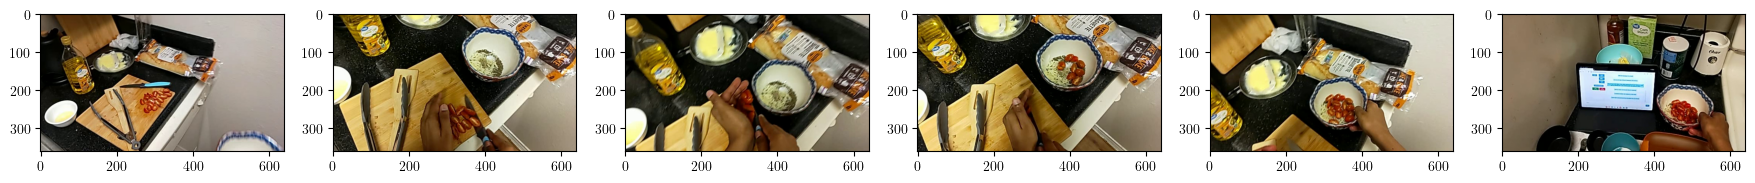


Prompt: <image>User: The person should be adding cut cherry tomatoes into a blender. At the end of the video, are the cherry tomatoes in the bowl? GPT: <answer>
Response: No, the bow is empty, and the video ends with the person showing off their finished dish.

Tokens:
inputs torch.Size([1, 42])
outputs torch.Size([1, 22])
['No', ',', 'the', 'bow', 'is', 'empty', ',', 'and', 'the', 'video', 'ends', 'with', 'the', 'person', 'showing', 'off', 'their', 'finished', 'd', 'ish', '.', '<|endofchunk|>']


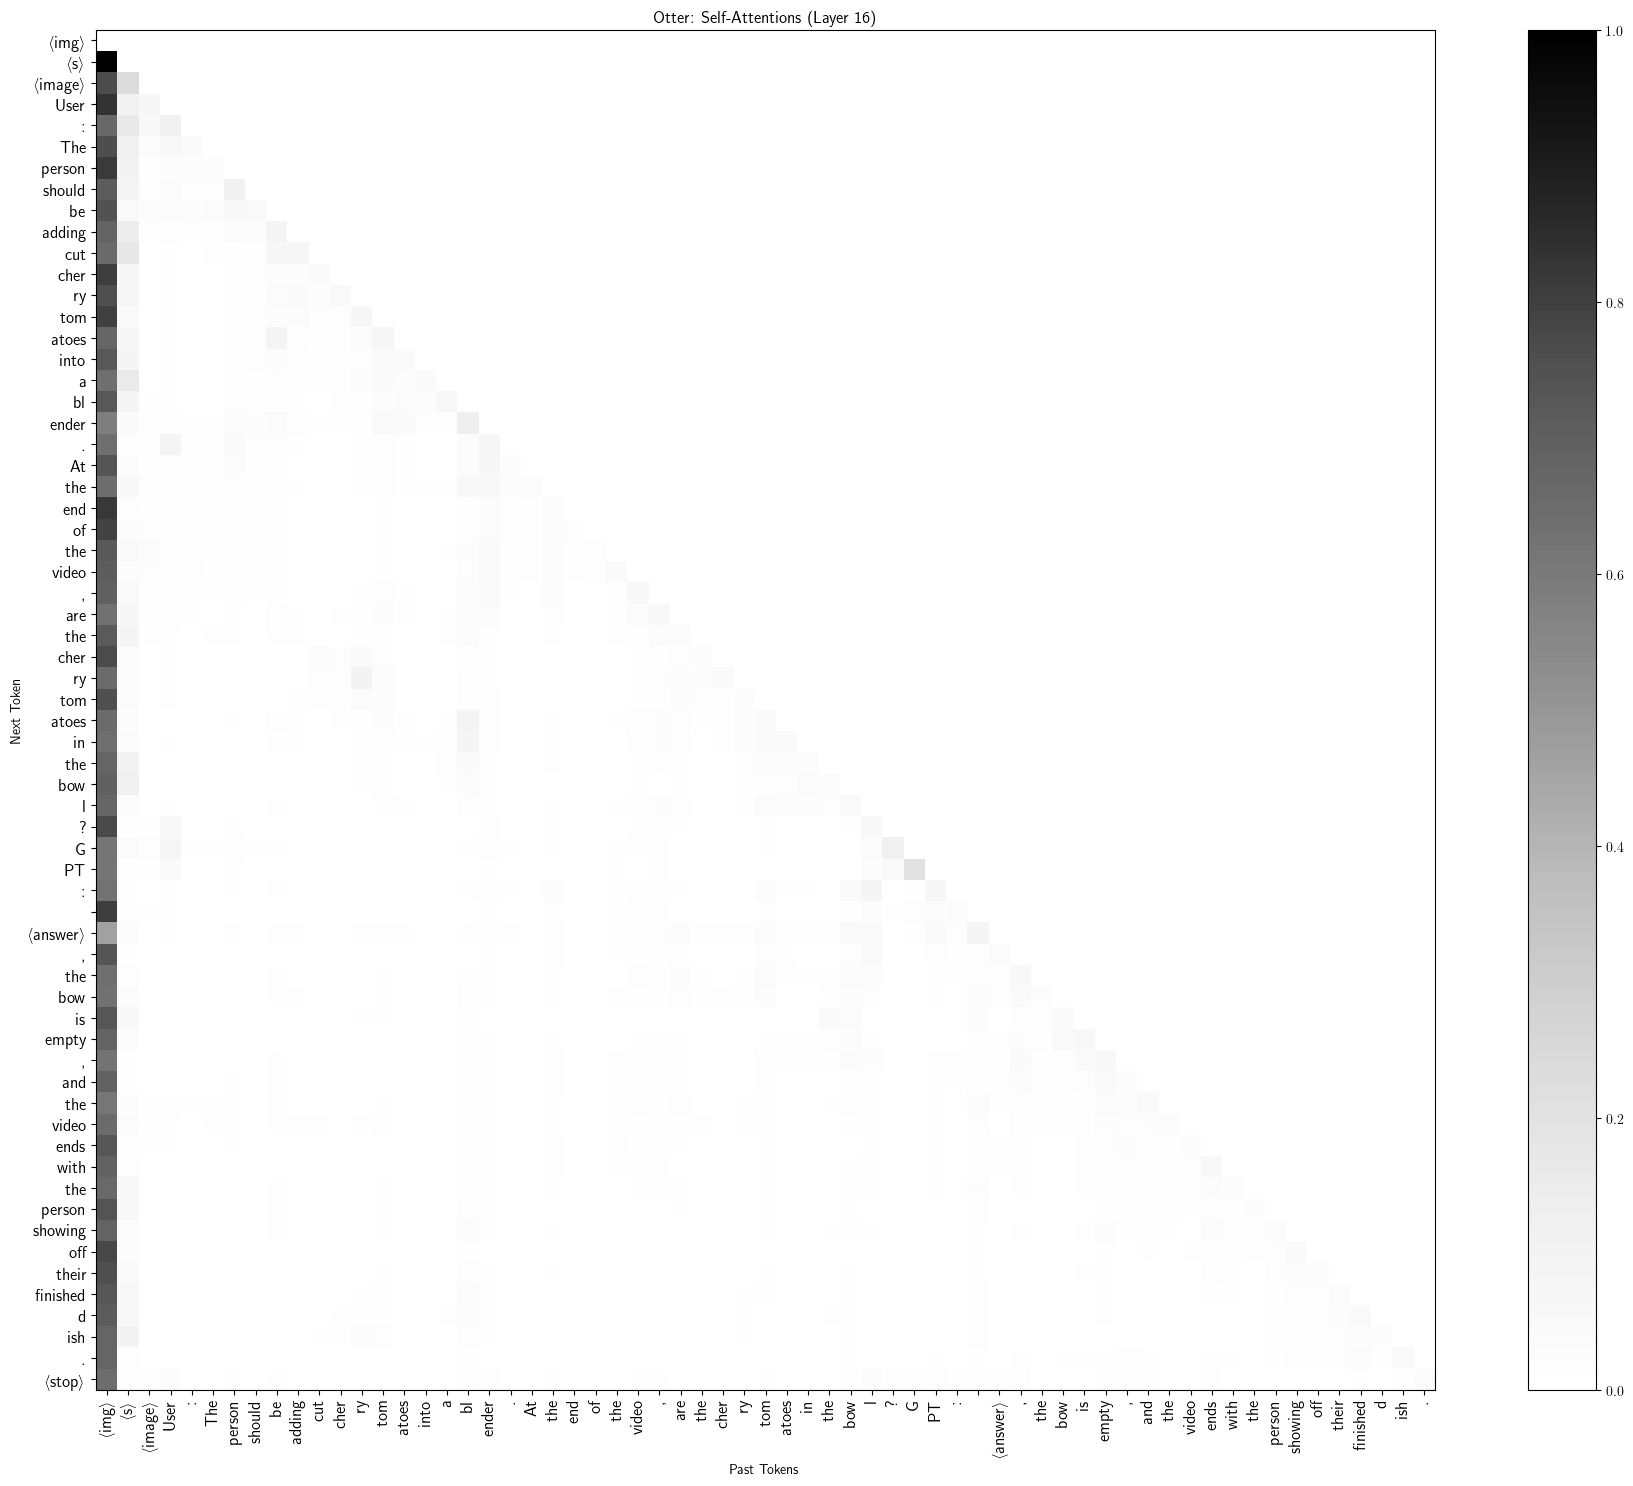

graphing layers: 100%|██████████| 32/32 [00:30<00:00,  1.04it/s]


In [102]:
from matplotlib import pyplot as plt
from tqdm import tqdm

# prompt = get_formatted_prompt("What is happening in this video?")
# prompt = get_formatted_prompt("The user should be placing cut cherry tomatoes in a bowl. What is happening in this video?" )
# prompt = get_formatted_prompt("What happened to the cherry tomatoes?")
# prompt = get_formatted_prompt("Did the person successfully add the cherry tomatoes in a bowl?")
# prompt = get_formatted_prompt("Did the person successfully juice the cherry tomatoes?")
# prompt = get_formatted_prompt("At the end of the video, are all the cherry tomatoes in the bowl?")
# prompt = get_formatted_prompt("At the end of the video, are any of the cherry tomatoes on the cutting board?")get_formatted_prompt(
# prompt = get_formatted_prompt("What is the state of the cherry tomatoes at the end of this video?")

# prompt = "<image>User: At the end of the video, where are the cherry tomatoes? GPT: At the end of the video, the cherry tomatoes are now located <answer>"
# prompt = "<image>User: The person should be adding cut cherry tomatoes into a bowl. At the end of the video, where are the cherry tomatoes? GPT: At the end of the video, the cherry tomatoes are now located <answer>"
# prompt = "<image>User: The person should be adding cut cherry tomatoes into a blender. At the end of the video, where are the cherry tomatoes? GPT: At the end of the video, the cherry tomatoes are now located <answer>"
# prompt = "<image>User: The person should be adding cut cherry tomatoes into a blender. At the end of the video, are the cherry tomatoes in the blender? GPT: <answer>"
prompt = "<image>User: The person should be adding cut cherry tomatoes into a blender. At the end of the video, are the cherry tomatoes in the bowl? GPT: <answer>"
# One possibility: use NER or object detection to extract all the main objects in the scene, then compare probability of target object being in/on them by filling prompt with each one
# ^ this issue on GitHub provides some code for such a function https://github.com/Luodian/Otter/issues/93


def get_formatted_prompt(prompt: str) -> str:
    return f"<image>User: {prompt} GPT:<answer>"

frames_list = all_frames[8] # This should be a list of three video frames showing sliced tomatoes being moved from a cutting board to a bowl

fig, axarr = plt.subplots(1, len(frames_list), figsize=(22, 4))
for frame, ax in zip(frames_list, axarr):
    if frame is not None:
        ax.imshow(frame)
plt.show()

print(f"\nPrompt: {prompt}")
input_ids = model.text_tokenizer(prompt, return_tensors="pt")['input_ids']
response, generated_ids, attentions = get_response(frames_list, prompt, model, image_processor, tensor_dtype)
generated_ids = generated_ids[:, input_ids.shape[1]:]
input_self_attention = attentions[0] # (TUPLE: # layers = 32, # beams, # attention heads = 32, # input tokens, # input tokens)
generation_attention = attentions[1:] # (TUPLE: # total generated tokens + 2, TUPLE: # layers = 32, # beams, # attention heads = 32, 1, # input tokens + # tokens generated so far)
# Why + 2?

print(f"Response: {response}")

print("\nTokens:")
print("inputs", input_ids.shape)
print("outputs", generated_ids.shape)
print([model.text_tokenizer.decode(token) for token in generated_ids[0]])

# print("\nAttentions:")
# print(len(attentions))
# for attention in attentions:
#     print('========')
#     print(len(attention))
#     for attention2 in attention:
#         print(attention2.shape)
        
graph_decoder_only_self_attention(attentions, 
                                  model.text_tokenizer, 
                                  input_ids, 
                                  1, 
                                  generated_ids, 
                                  layer_idx=15, 
                                  name="Otter", 
                                  return_image=False,
                                  condensed_graph=False,
                                  exclude_img_cls_token=False)

SAVE_FOLDER = "attention_graphs"
graphs = []
for l_idx in tqdm(range(model.config.text_config.num_hidden_layers), desc="graphing layers"):
    img = graph_decoder_only_self_attention(attentions, 
                                      model.text_tokenizer, 
                                      input_ids, 
                                      1, 
                                      generated_ids, 
                                      layer_idx=l_idx, 
                                      name="Otter", 
                                      condensed_graph=True,
                                      save_folder=SAVE_FOLDER,
                                      return_image=True,
                                      exclude_img_cls_token=False)    
    graphs.append(img)
graphs[0].save(os.path.join(SAVE_FOLDER, 'attention_VLM_all.gif'),
               save_all=True, 
               append_images=graphs[1:],
               duration=1000, 
               loop=0)

## OWL-ViT demo

### Model setup

In [71]:
import requests
from PIL import Image
import torch

from transformers import OwlViTProcessor, OwlViTForObjectDetection
from transformers import Owlv2Processor, Owlv2ForObjectDetection

# MODEL_NAME = "google/owlvit-base-patch32"
# processor = OwlViTProcessor.from_pretrained(MODEL_NAME)
# model = OwlViTForObjectDetection.from_pretrained(MODEL_NAME)

MODEL_NAME = "google/owlv2-base-patch16"
processor = Owlv2Processor.from_pretrained(MODEL_NAME)
model = Owlv2ForObjectDetection.from_pretrained(MODEL_NAME)

Utils function for showing bboxes on image:

In [86]:
# adapted from Kosmos-2 code

from PIL import Image
import torch
import os
import numpy as np
import cv2
import requests
import torchvision.transforms as T
import matplotlib.pyplot as plt
from transformers.utils.constants import OPENAI_CLIP_MEAN, OPENAI_CLIP_STD

def is_overlapping(rect1, rect2):
    x1, y1, x2, y2 = rect1
    x3, y3, x4, y4 = rect2
    return not (x2 < x3 or x1 > x4 or y2 < y3 or y1 > y4)

def draw_entity_boxes_on_image(image, entities, show=False, save_path=None):
    """_summary_
    Args:
        image (_type_): image or image path
        collect_entity_location (_type_): _description_
    """
    if isinstance(image, Image.Image):
        image_h = image.height
        image_w = image.width
        image = np.array(image)[:, :, [2, 1, 0]]
    elif isinstance(image, str):
        if os.path.exists(image):
            pil_img = Image.open(image).convert("RGB")
            image = np.array(pil_img)[:, :, [2, 1, 0]]
            image_h = pil_img.height
            image_w = pil_img.width
        else:
            raise ValueError(f"invaild image path, {image}")
    elif isinstance(image, torch.Tensor):
        # pdb.set_trace()
        image_tensor = image.cpu()
        reverse_norm_mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])[:, None, None]
        reverse_norm_std = torch.tensor([0.26862954, 0.26130258, 0.27577711])[:, None, None]
        image_tensor = image_tensor * reverse_norm_std + reverse_norm_mean
        pil_img = T.ToPILImage()(image_tensor)
        image_h = pil_img.height
        image_w = pil_img.width
        image = np.array(pil_img)[:, :, [2, 1, 0]]
    else:
        raise ValueError(f"invaild image format, {type(image)} for {image}")

    if len(entities) == 0:
        return image

    new_image = image.copy()
    previous_bboxes = []
    # size of text
    text_size = 1
    # thickness of text
    text_line = 1  # int(max(1 * min(image_h, image_w) / 512, 1))
    box_line = 3
    (c_width, text_height), _ = cv2.getTextSize("F", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
    base_height = int(text_height * 0.675)
    text_offset_original = text_height - base_height
    text_spaces = 3

    for entity_name, bboxes in entities:
        for (x1_norm, y1_norm, x2_norm, y2_norm) in bboxes:
            orig_x1, orig_y1, orig_x2, orig_y2 = int(x1_norm * image_w), int(y1_norm * image_h), int(x2_norm * image_w), int(y2_norm * image_h)
            # draw bbox
            # random color
            color = tuple(np.random.randint(0, 255, size=3).tolist())
            new_image = cv2.rectangle(new_image, (orig_x1, orig_y1), (orig_x2, orig_y2), color, box_line)

            l_o, r_o = box_line // 2 + box_line % 2, box_line // 2 + box_line % 2 + 1

            x1 = orig_x1 - l_o
            y1 = orig_y1 - l_o

            if y1 < text_height + text_offset_original + 2 * text_spaces:
                y1 = orig_y1 + r_o + text_height + text_offset_original + 2 * text_spaces
                x1 = orig_x1 + r_o

            # add text background
            (text_width, text_height), _ = cv2.getTextSize(f"  {entity_name}", cv2.FONT_HERSHEY_COMPLEX, text_size, text_line)
            text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2 = x1, y1 - (text_height + text_offset_original + 2 * text_spaces), x1 + text_width, y1

            for prev_bbox in previous_bboxes:
                while is_overlapping((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2), prev_bbox):
                    text_bg_y1 += (text_height + text_offset_original + 2 * text_spaces)
                    text_bg_y2 += (text_height + text_offset_original + 2 * text_spaces)
                    y1 += (text_height + text_offset_original + 2 * text_spaces)

                    if text_bg_y2 >= image_h:
                        text_bg_y1 = max(0, image_h - (text_height + text_offset_original + 2 * text_spaces))
                        text_bg_y2 = image_h
                        y1 = image_h
                        break

            alpha = 0.5
            for i in range(text_bg_y1, text_bg_y2):
                for j in range(text_bg_x1, text_bg_x2):
                    if i < image_h and j < image_w:
                        if j < text_bg_x1 + 1.35 * c_width:
                            # original color
                            bg_color = color
                        else:
                            # white
                            bg_color = [255, 255, 255]
                        new_image[i, j] = (alpha * new_image[i, j] + (1 - alpha) * np.array(bg_color)).astype(np.uint8)

            cv2.putText(
                new_image, f"  {entity_name}", (x1, y1 - text_offset_original - 1 * text_spaces), cv2.FONT_HERSHEY_COMPLEX, text_size, (0, 0, 0), text_line, cv2.LINE_AA
            )
            # previous_locations.append((x1, y1))
            previous_bboxes.append((text_bg_x1, text_bg_y1, text_bg_x2, text_bg_y2))

    pil_image = Image.fromarray(new_image[:, :, [2, 1, 0]])
    if save_path:
        pil_image.save(save_path)
    if show:
        fig, ax = plt.subplots(figsize=(16, 12))
        ax.imshow(pil_image)
        plt.show()
    return new_image

def convert_bbox(center_x, center_y, width, height):
    top_left_x = center_x - width / 2
    top_left_y = center_y - height / 2
    bottom_right_x = center_x + width / 2
    bottom_right_y = center_y + height / 2
    return (top_left_x, top_left_y, bottom_right_x, bottom_right_y)

def get_preprocessed_image(pixel_values):
    pixel_values = pixel_values.squeeze().numpy()
    unnormalized_image = (pixel_values * np.array(OPENAI_CLIP_STD)[:, None, None]) + np.array(OPENAI_CLIP_MEAN)[:, None, None]
    unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
    unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
    unnormalized_image = Image.fromarray(unnormalized_image)
    return unnormalized_image

### Model prompting

In [84]:
from collections import defaultdict
from PIL import Image

# image = Image.fromarray(all_frames[8][0]) # This should be an image of sliced tomatoes on only a cutting board
image = Image.fromarray(all_frames[8][1]) # This should be an image of sliced tomatoes on a cutting board and in a bowl
# image = Image.fromarray(all_frames[8][2]) # This should be an image of sliced tomatoes in only a bowl
# image = Image.fromarray(all_frames[8][3]) # This should be an image of sliced tomatoes in only a bowl
# image = Image.fromarray(all_frames[8][4]) # This should be an image of sliced tomatoes in only a bowl

texts = [["a photo of cherry tomatoes", "a photo of a bowl", "a photo of a cutting board", "a photo of a hand", "a photo of a knife"]]
inputs = processor(text=texts, images=image, return_tensors="pt")
outputs = model(**inputs)

Visualize OWL-ViT outputs:

Detected a photo of a cutting board with confidence 0.362 at location [43.41, 0.5, 314.93, 175.68]
Detected a photo of a cutting board with confidence 0.482 at location [140.43, 237.09, 542.47, 545.35]
Detected a photo of a knife with confidence 0.338 at location [319.45, 266.62, 516.67, 295.5]
Detected a photo of a knife with confidence 0.226 at location [253.09, 288.51, 356.79, 477.68]
Detected a photo of cherry tomatoes with confidence 0.227 at location [393.46, 295.12, 521.69, 392.44]
Detected a photo of a knife with confidence 0.2 at location [288.82, 296.21, 397.45, 533.41]


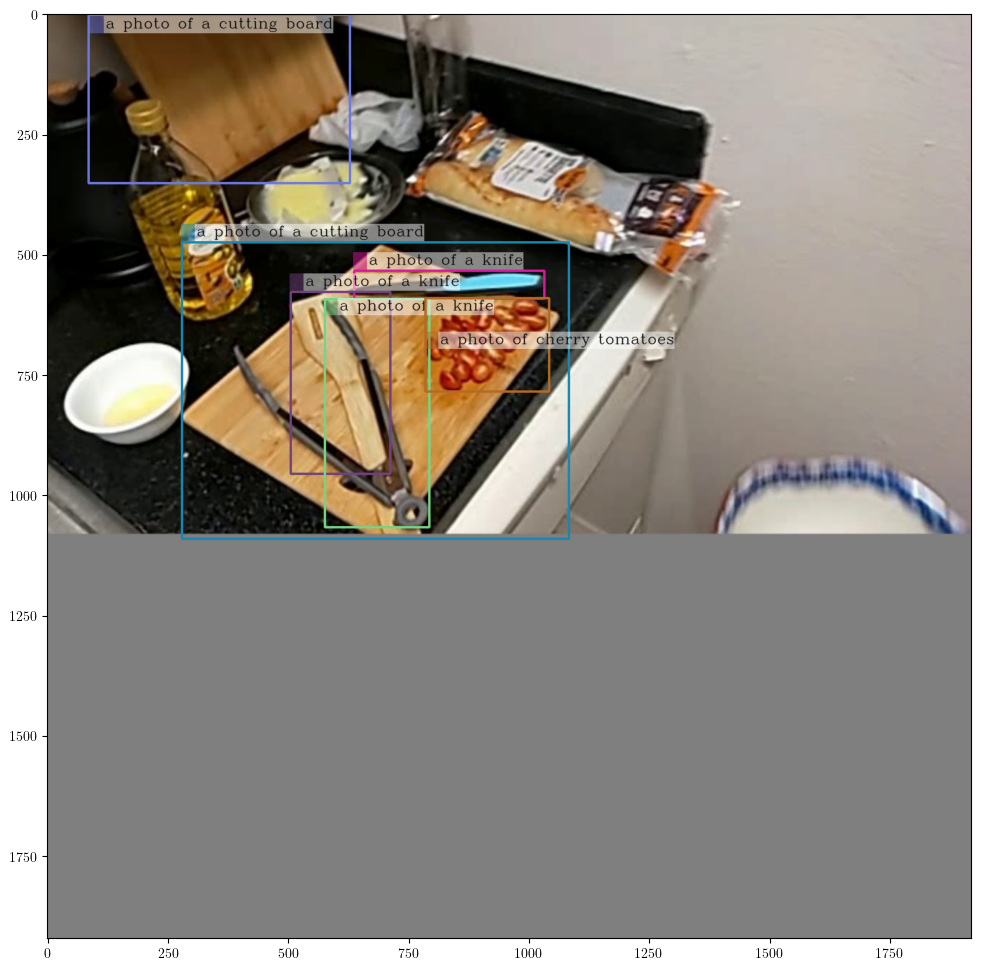

array([[[ 65,  82,  97],
        [ 65,  82,  97],
        [ 64,  81,  97],
        ...,
        [182, 183, 193],
        [182, 183, 193],
        [182, 183, 193]],

       [[ 65,  82,  97],
        [ 65,  82,  97],
        [ 64,  81,  97],
        ...,
        [182, 183, 193],
        [182, 183, 193],
        [182, 183, 193]],

       [[ 65,  82,  98],
        [ 65,  82,  98],
        [ 65,  82,  97],
        ...,
        [182, 183, 193],
        [182, 183, 193],
        [182, 183, 193]],

       ...,

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]],

       [[127, 127, 127],
        [127, 127, 127],
        [127, 127, 127],
        ...,
        [127, 127, 127],
        [127, 127, 127],
        [127, 127, 127]]

In [90]:
# For owlv2, add padding to image
if "owlv2" in MODEL_NAME:
    padded_image = get_preprocessed_image(inputs.pixel_values)
else:
    padded_image = image

# Target image sizes (height, width) to rescale box predictions [batch_size, 2]
target_sizes = torch.Tensor([padded_image.size[::-1]])
# Convert outputs (bounding boxes and class logits) to Pascal VOC format (xmin, ymin, xmax, ymax)
results = processor.post_process_object_detection(outputs=outputs, target_sizes=target_sizes, threshold=0.2)
i = 0  # Retrieve predictions for the first image for the corresponding text queries
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

entities = defaultdict(list)
for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
        
    box_norm = (box[0] / padded_image.width, box[1] / padded_image.height, box[2] / padded_image.width, box[3] / padded_image.height)
    print(f"Detected {text[label]} with confidence {round(score.item(), 3)} at location {box}")
    
    entities[text[label]].append(box_norm)

entities = [(entity, boxes) for entity, boxes in entities.items()]    
draw_entity_boxes_on_image(padded_image.resize((padded_image.width*2, padded_image.height*2)), entities, show=True)

# EPIC KITCHENS

In [ ]:
import pandas as pd

# PARTITION = "validation"
PARTITION = "train"
EK_ANNOTATION_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/annotations/EPIC_100_{PARTITION}_full_sent.csv"
annotations = pd.read_csv(EK_ANNOTATION_PATH)
EK_55_VIDEO_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/55"
EK_100_VIDEO_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS/100"


# # Load visual annotations
# NOUN_CLASSES_PATH = "/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS-VISOR/2v6cgv1x04ol22qp9rm9x2j6a7/EPIC_100_noun_classes_v2.csv"
# EK_VISUAL_ANNOTATION_PATH = f"/nfs/turbo/coe-chaijy/datasets/EPIC-KITCHENS-VISOR/2v6cgv1x04ol22qp9rm9x2j6a7/GroundTruth-SparseAnnotations/annotations/{PARTITION}"

## 1 recipe, 2 video clips formulation

Collect lists of clips for all videos in EPIC KITCHENS:

In [ ]:
from pprint import pprint
from tqdm import tqdm
from collections import defaultdict
from datetime import datetime
import json
import os
import numpy as np

structured_action_lists = defaultdict(dict)

for row_idx, row in tqdm(annotations.iterrows(), total=len(annotations)):
    
    participant_index, video_index, clip_index = row['narration_id'].split('_')
    video_index = participant_index + "_" + str(video_index)
    clip_index = int(clip_index)

    narration_text = row['full_sent_narration']
    
    start_timestamp = row['start_timestamp']
    start_timestamp = datetime.strptime(start_timestamp, "%H:%M:%S.%f")
    stop_timestamp = row['stop_timestamp']
    stop_timestamp = datetime.strptime(stop_timestamp, "%H:%M:%S.%f")
    action_seconds = stop_timestamp - start_timestamp
    action_seconds = action_seconds.total_seconds()
    
    verb = row['verb']
    noun = row['noun'] # TODO: "all_nouns" key gives access to other noun participants where applicable

    structured_action_lists[video_index][clip_index] = {
        "video_id": video_index,
        "clip_index": clip_index,
        "verb": verb,
        "noun": noun,
        "all_nouns": eval(row["all_nouns"]),
        "narration_text": narration_text,
        "action_seconds": action_seconds,
        "start_timestamp": row['start_timestamp'],
        "stop_timestamp": row['stop_timestamp'],
    }
    
print(f"{len(structured_action_lists)} videos collected from EPIC KITCHENS")

# smooth out to a dict of lists
for video_id in structured_action_lists:
    min_clip_id = min(list(structured_action_lists[video_id].keys()))
    max_clip_id = max(list(structured_action_lists[video_id].keys()))
    
    new_list = []
    last_action = None
    for clip_id in range(min_clip_id, max_clip_id+1):
        
        if clip_id not in structured_action_lists[video_id]:
            continue
        
        current_action = structured_action_lists[video_id][clip_id]
        new_list.append(current_action)
        
    structured_action_lists[video_id] = new_list

Retrieve clips for TRAVEl examples:

In [ ]:
from pprint import pprint

query_verb = "roll"
query_nouns = {"tortilla",}

retrieved_clips = []
for video in structured_action_lists:
    for clip in structured_action_lists[video]:
        if clip['verb'] == query_verb and set(clip['all_nouns']) == set(query_nouns):
            retrieved_clips.append(clip)

print(f"{len(retrieved_clips)} clips retrieved from {PARTITION} partition of EK-100")
videos_to_look_at = list(set([clip['video_id'] for clip in retrieved_clips]))
print("In videos:", videos_to_look_at)

for clip in retrieved_clips:
    pprint(
        {
            "video_id": clip['video_id'],
            # "clip_index": clip['clip_index'],
            # "verb": clip['verb'],
            # "all_nouns": clip['all_nouns'],
            "start_timestamp": clip['start_timestamp'],
            "stop_timestamp": clip['stop_timestamp'],            
        }
    )

Retrieve videos for clips:

In [ ]:
import torch
from video_blip.data.epic_kitchens import EpicKitchensDataset

dataset = EpicKitchensDataset(EK_ANNOTATION_PATH,
                              EK_55_VIDEO_PATH,
                              EK_100_VIDEO_PATH,
                              )

In [ ]:
for item in dataset:
    pprint(item)
    break